### Index
<b><ol>1 Introduction<br>
    2 Import Python Packages and Data<br>
    3 Data Understanding<br>
    4 Preprocessing<br>
    5 WordCloud<br>
    6 Data Modeling and Evaluation<br>
    7 Report
    </ol></b>

### 1 Introduction

##### Competition Description
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

In this competition, build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t using access to a dataset of 10,000 tweets that were hand classified.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

##### Acknowledgments
This dataset was created by the company figure-eight and originally shared on their [‘Data For Everyone’ website here](https://www.figure-eight.com/data-for-everyone/).

##### Evaluation
Submissions are evaluated using F1 between the predicted and expected answers.

F1 is calculated as follows:<br>
$$F1=2∗ \frac {precision∗recall} {precision+recall}$$
where:

$$precision= \frac {TP} {TP+FP}$$<br>
$$recall= \frac {TP} {TP+FN}$$
and:

> True Positive [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a *positive* and that's *true*!<br>
False Positive [FP] = your prediction is 1, and the ground truth is 0 - you predicted a *positive*, and that's *false*.<br>
False Negative [FN] = your prediction is 0, and the ground truth is 1 - you predicted a *negative*, and that's *false*.<br>

##### Submission File
For each ID in the test set, 1 if the tweet is describing a real disaster, and 0 otherwise. The file should contain a header and have the following format:

`id,target`<br>
`0,0`<br>
`2,0`<br>
`3,1`<br>
`9,0`<br>
`11,0`<br>

### 2 Import Python Packages and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import re
import string
import stopwords
import nltk
import random
from wordcloud import WordCloud
from nltk.corpus import stopwords
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("../train.csv")
test = pd.read_csv("../test.csv")

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 208.2+ KB


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 63.8+ KB


### 3 Data Understanding

In [7]:
train.loc[train.target == 0]

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0
7587,10841,NaN,NaN,Sirens everywhere!,0


In [8]:
train.loc[train.target == 1]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [9]:
train.groupby('target').nunique()

,id,keyword,location,text
target,,,,
0,4342,218,2142,4315
1,3271,220,1513,3206


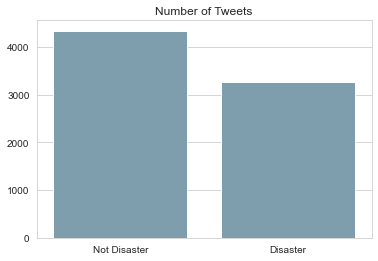

In [10]:
sns.set_style(style="whitegrid")
sns.barplot(train.groupby('target').nunique().index, train.target.value_counts(), color='#77a1b5')
plt.title('Number of Tweets')
plt.xticks([0,1],['Not Disaster','Disaster'])
plt.xlabel("")
plt.ylabel("")
plt.savefig('target.png')

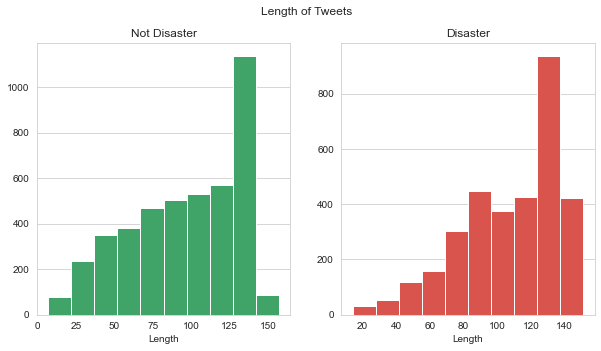

In [11]:
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(train[train['target']==0].text.str.len(), color="#40a368") 
ax1.set(xlabel='Length', title='Not Disaster')
ax1.grid(axis='x')
ax2.hist(train[train['target']==1].text.str.len(), color="#d9544d") 
ax2.set(xlabel='Length', title='Disaster')
ax2.grid(axis='x')
f.suptitle('Length of Tweets')
plt.savefig('length.png')

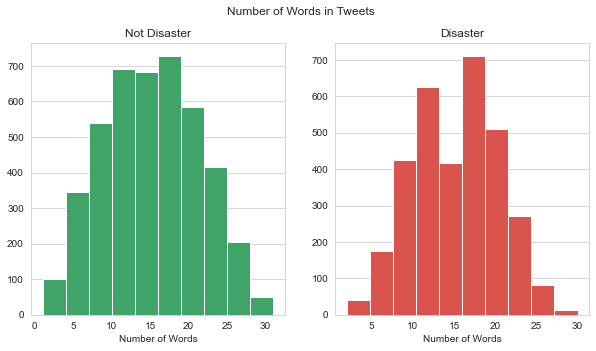

In [12]:
# number of words per tweet
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(train[train['target']==0].text.str.split().map(lambda x: len(x)), color="#40a368") 
ax1.set(xlabel='Number of Words', title='Not Disaster')
ax1.grid(axis='x')
ax2.hist(train[train['target']==1].text.str.split().map(lambda x: len(x)), color="#d9544d") 
ax2.set(xlabel='Number of Words', title='Disaster')
ax2.grid(axis='x')
f.suptitle('Number of Words in Tweets')
plt.savefig('words.png')

In [13]:
keyword = train.groupby('keyword').nunique()
keyword.drop(['location','text'], axis=1, inplace=True)
keyword.rename(columns={'id':'count'}, inplace=True)
keyword

,count,target
keyword,,
ablaze,36,2
accident,35,2
aftershock,34,1
airplane%20accident,35,2
ambulance,38,2
...,...,...
wounded,37,2
wounds,33,2
wreck,37,2


In [14]:
train.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [15]:
keyword.index = keyword.index.to_series().replace({'annihilated':'annihilation', 'arsonist':'arson', 'attacked':'attack','bioterrorism':'bioterror', 'blazing':'blaze',
                                                  'bloody':'blood', 'body%20bagging':'body%20bag', 'body%20bags':'body%20bag', 'bombed':'bomb', 'bombing':'bomb', 
                                                  'buildings%20on%20fire':'buildings%20burning', 'burning%20buildings':'buildings%20burning', 'burning':'burned', 
                                                  'casualties':'casualty', 'catastrophic':'catastrophe', 'collapsed':'collapse', 'collided':'collide', 
                                                  'collision':'collide', 'crashed':'crash', 'crushed':'crush', 'death':'dead', 'deaths':'dead', 'deluged':'deluge', 
                                                  'demolished':'demolish', 'demolition':'demolish', 'derailed':'derail', 'derailment':'derail', 
                                                  'desolation':'desolate', 'destroyed':'destroy', 'destruction':'destroy', 'detonation':'detonate', 
                                                  'devastation':'devastated', 'drowned':'drown', 'drowning':'drown', 'electrocuted':'electrocute', 
                                                  'emergency%20plan':'emergency%20services', 'evacuated':'evacuate', 'evacuation':'evacuate', 
                                                  'exploded':'explode', 'explosion':'explode', 'fatalities':'fatal', 'fatality':'fatal', 'flooding':'flood', 
                                                  'floods':'flood', 'forest%20fires':'forest%20fire', 'hailstorm':'hail', 'hazardous':'hazard', 'hijacker':'hijack', 
                                                  'hijacking':'hijack', 'hostages':'hostage', 'injured':'injury', 'injuries':'injury', 'inundation':'inundated', 
                                                  'mass%20murderer':'mass%20murder', 'massacre':'mass%20murder', 'obliterated':'obliterate', 
                                                  'obliteration':'obliterate', 'panicking':'panick', 'quarantined':'quarantine', 'rescued':'rescue', 
                                                  'rescuers':'rescue', 'rioting':'riot', 'screamed':'screams', 'screaming':'screams', 'sinkhole':'sinking', 
                                                  'sirens':'siren', 'suicide%20bomber':'suicide%20bomb', 'suicide%20bombing':'suicide%20bomb', 
                                                  'survived':'survive', 'survivors':'survive', 'terrorist':'terrorism', 'thunderstorm':'thunder', 
                                                  'traumatised':'trauma', 'violent%20storm':'storm', 'weapons':'weapon', 'wild%20fires':'wildfire', 
                                                  'wounded':'wounds', 'wreckage':'wreck', 'wrecked':'wreck'}) 

In [16]:
keyword = keyword.groupby(keyword.index, sort=False).sum()
keyword.sort_values(by='count', ascending=False, inplace=True)
keyword

,count,target
keyword,,
fatal,120,6
wreck,115,5
collide,113,6
evacuate,112,6
derail,112,5
...,...,...
bush%20fires,25,2
war%20zone,24,2
epicentre,12,2


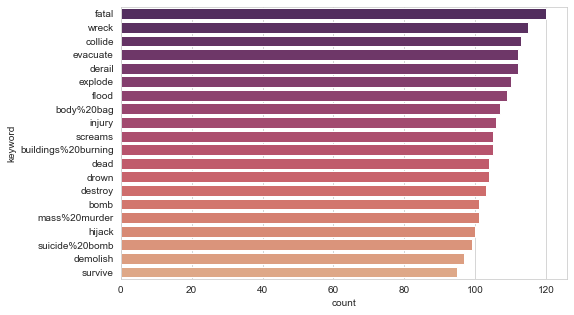

In [17]:
plt.figure(figsize=(8, 5))
sns.barplot(y=keyword[:20].index, x=keyword['count'][:20], orient='h', palette='flare_r')
plt.savefig('keyword.png')

In [18]:
keyword.sort_values(by='target', ascending=False, inplace=True)
keyword.reset_index(drop=False, inplace=True)
keyword.set_index('target', drop=True, inplace=True)
keyword = keyword.groupby('target')['keyword'].apply(lambda x: ', '.join(x.astype(str))).reset_index()

In [19]:
print("List of keywords that have n number of target tweets each")
print(keyword.set_index('target').to_string())

List of keywords that have n number of target tweets each
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               keyword
target 

In [20]:
location = train.groupby('location').nunique()
location.drop(['keyword','text'], axis=1, inplace=True)
location.rename(columns={'id':'count'}, inplace=True)
location

,count,target
location,,
,1,1
Glasgow,1,1
"Melbourne, Australia",1,1
News,1,1
å_,1,1
...,...,...
å_: ?? ÌÑ ? : ?,1,1
å_å_Los Mina Cityã¢,1,1
å¡å¡Midwest Û¢Û¢,1,1


In [21]:
location.index = location.index.to_series().replace({'United States':'US', 'New York':'US', "London":'UK', "Los Angeles, CA":'US', "Washington, D.C.":'US', 
                                                     "California":'US', "Chicago, IL":'US', "Chicago":'US', "New York, NY":'US', "California, USA":'US', 
                                                     "FLorida":'US', "Nigeria":'Africa', "Kenya":'Africa', "Everywhere":'Worldwide', "San Francisco":'US', 
                                                     "Florida":'US', "United Kingdom":'UK', "Los Angeles":'US', "Toronto":'Canada', "San Francisco, CA":'US', 
                                                     "NYC":'US', "Seattle":'US', "Earth":'Worldwide', "Ireland":'UK', "London, England":'UK', "New York City":'US', 
                                                     "Texas":'US', "London, UK":'UK', "Atlanta, GA":'US', "Mumbai":"India", 'Washington, DC':'US', 
                                                     'Sacramento, CA':'US', 'San Diego, CA':'US', 'Dallas, TX':'US', 'Nashville, TN':'US', 'Denver, Colorado':'US', 
                                                     'Manchester':'US', 'World':'Worldwide', 'Scotland':'UK', 'Houston, TX':'US', 'Austin, TX':'US', 
                                                     'Memphis, TN':'US', 'Denver, CO':'US', 'Seattle, WA':'US', 'Tennessee':'US', 'Pennsylvania, USA':'US', 
                                                     'Sydney':'Australia', 'worldwide':'Worldwide', 'Portland, OR':'US', 'Colorado':'US', 'Planet Earth':'Worldwide', 
                                                     'Massachusetts':'US', 'Atlanta':'US', 'Oklahoma City, OK':'US', 'Orlando, FL':'US', 'Paterson, New Jersey':'US', 
                                                     'Charlotte, NC':'US', 'California, United States':'US', 'Pedophile hunting ground':'Worldwide', 
                                                     'Calgary, Alberta':'Canada', 'Global':'Worldwide', 'Road to the Billionaires Club':'Worldwide', 
                                                     '??????':'Worldwide', 'Brooklyn, NY':'US', 'Newcastle':'UK', 'Indiana':'US', 'Boston, MA':'US', 
                                                     'Calgary, AB':'Canada', 'Puerto Rico':'US', 'NY':'US', 'Wisconsin':'US', 'Coventry':'UK', 'North Carolina':'US', 
                                                     'Vancouver, BC':'Canada', 'Lagos, Nigeria':'Africa', 'New Jersey':'US', 'Melbourne, Australia':'Australia', 
                                                     'WorldWide':'Worldwide', 'Cleveland, OH':'US', 'New Hampshire':'US', 'Pennsylvania':'US', 'Newcastle':'UK', 
                                                     'Indiana':'US', 'in the Word of God':'Worldwide', 'New York, USA':'US', 'Leeds, England':'UK', 
                                                     'Florida, USA':'US', 'San Jose, CA':'US', 'Asheville, NC':'US', 'Texas, USA':'US', 'Southern California':'US', 
                                                     'Oakland, CA':'US', 'Midwest':'US', 'Michigan':'US', 'Mumbai, Maharashtra':'India', 'Melbourne':'Canada', 
                                                     'North Carolina, USA':'US', 'Oregon':'US', 'Birmingham':'US', 'Massachusetts, USA':'US', 'Maryland':'US', 
                                                     'Paignton':'UK', 'Edinburgh':'UK', 'San Francisco Bay Area':'US', 'Bend, Oregon':'US', 'U.S.A':'US', 
                                                     'British Columbia, Canada':'Canada', 'Manchester, England':'UK', 'USA':'US', 'ss':'Worldwide', '304':'Worldwide', 
                                                     'Paterson, New Jersey':'US', 'Tampa, FL':'US', 'Las Vegas, Nevada':'US', 'Republic of Texas':'US', 
                                                     'Phoenix, AZ':'US', 'Kansas City':'US', 'canada':'Canada', 'Haddonfield, NJ':'US', 'Seattle, Washington':'US', 
                                                     '?':'Worldwide', '??':'Worldwide', '?????':'US', 'Portland, Oregon':'US', 'london':'UK', 'Cape Town':'Africa', 
                                                     '':'Worldwide', '???':'Worldwide', '????':'Worldwide', 'Gotham City':'Worldwide', 'Anonymous':'US', 
                                                     'America':'US'})

In [22]:
location = location.groupby(location.index, sort=False).sum()
location.sort_values(by='count', ascending=False, inplace=True)
location.loc[location['count'] >= 30]

,count,target
location,,
US,801,153
UK,157,25
Worldwide,130,34
Canada,69,15
Africa,60,9
India,50,6
Australia,30,6


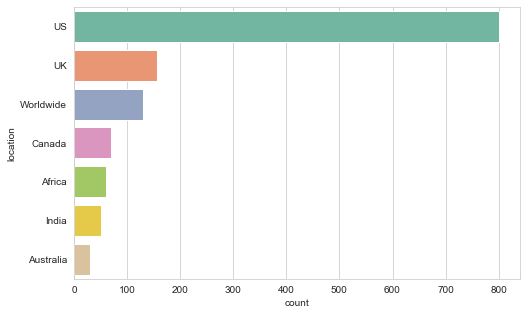

In [23]:
plt.figure(figsize=(8, 5))
sns.barplot(y=location.loc[location['count'] >= 30].index, x=location.loc[location['count'] >= 30]['count'][:20], orient='h', palette='Set2')
plt.savefig('location.png')

### 4 Preprocessing

#### Data Cleaning - lowercase, remove emojis, links, html tags, punctuation, stopwords, words containing numbers

In [24]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Applying the remove_emoji function to both test and training datasets
train['text'] = train['text'].apply(lambda x: remove_emoji(x))
test['text'] = test['text'].apply(lambda x: remove_emoji(x))

In [25]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = text.split()  
    text = [w for w in text if not w in set(stopwords.words('english'))] 
    text = ' '.join(text)  
    return text

# Applying the clean_text function to both test and training datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

In [26]:
# tweets in the train and test datasets after preprocessing
print("Rendered tweets in the train dataset, first 10:")
print(train.text[0:10])
print("_" * 60 + "\n")
print("Rendered tweets in the test dataset, first 10:")
print(test.text[0:10])

Rendered tweets in the train dataset, first 10:
0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
5    rockyfire update california hwy closed directi...
6    flood disaster heavy rain causes flash floodin...
7                           im top hill see fire woods
8    theres emergency evacuation happening building...
9                        im afraid tornado coming area
Name: text, dtype: object
____________________________________________________________

Rendered tweets in the test dataset, first 10:
0                          happened terrible car crash
1    heard earthquake different cities stay safe ev...
2    forest fire spot pond geese fleeing across str...
3                apocalypse lighting spokane wildfires
4                  typhoon soudelor kills china

### 5 WordCloud

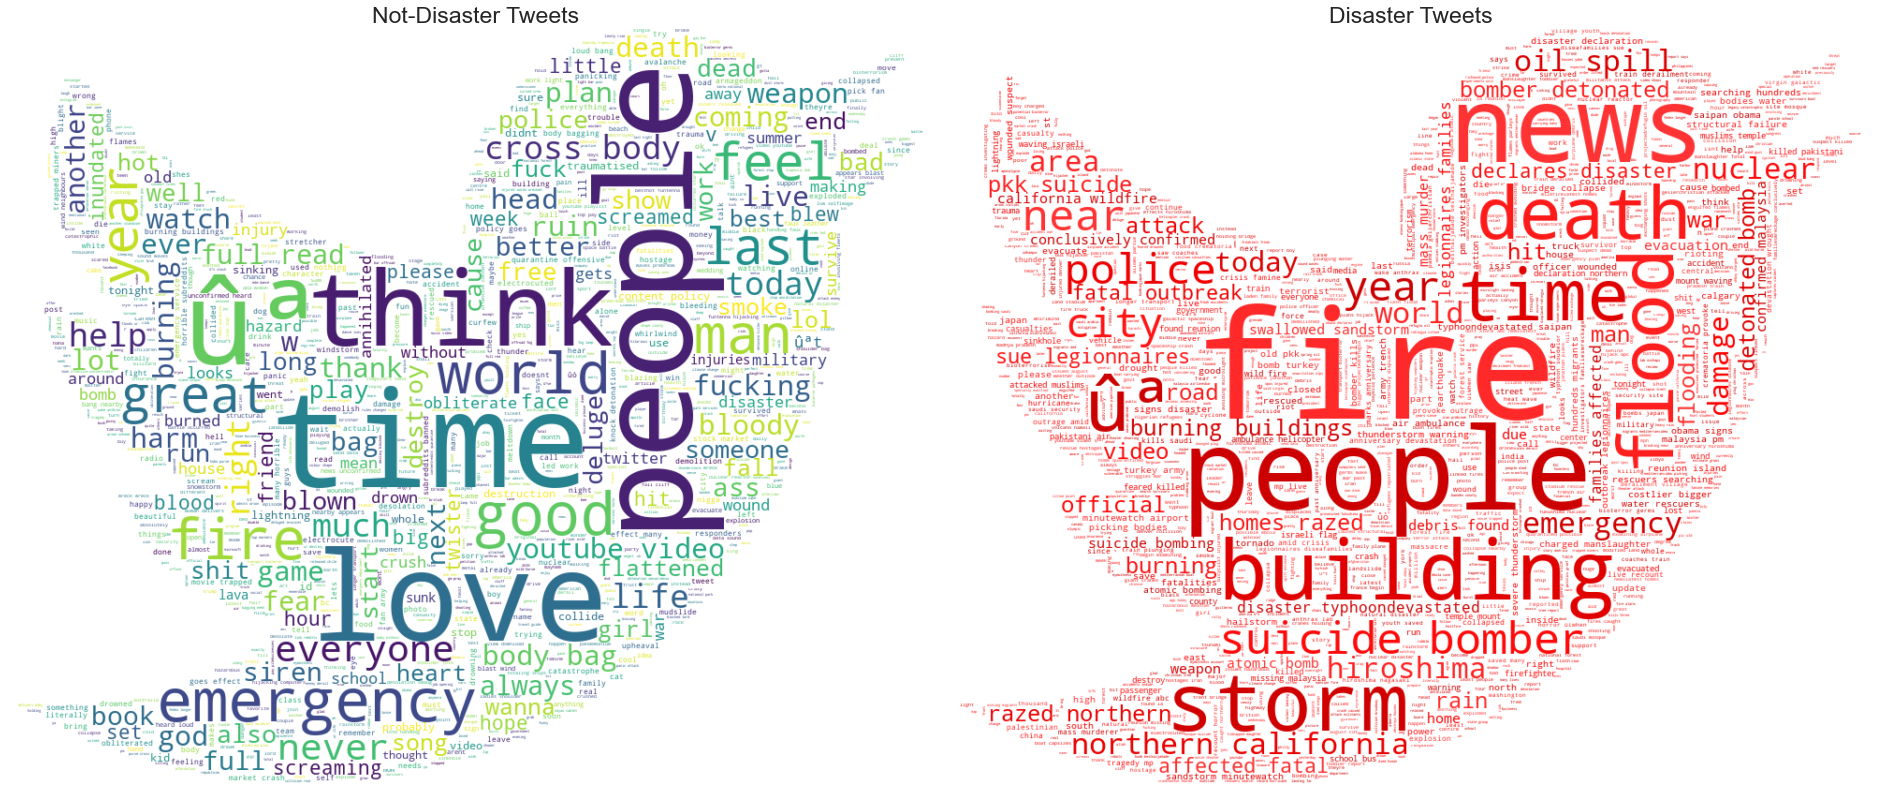

In [27]:
not_disaster = train[train.target == 0].reset_index(drop=True)
disaster = train[train.target == 1].reset_index(drop=True)

text_not_disaster = ''
for i in range(len(not_disaster.text)):
    text_not_disaster = text_not_disaster + not_disaster.text.loc[i]

text_disaster = ''
for i in range(len(disaster.text)):
    text_disaster = text_disaster + disaster.text.loc[i]
    
def red_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 100%%, %d%%)" % random.randint(40, 60)
    
stopwords = stopwords.words('english')
addition = {'via', 'one', 'back', 'im', 'u', 'say', 'new', 'would', 'like', 'dont', 'see', 'get', 'day', 'go', 'still', 'way', 'know', 'cant', 
            'two', 'come', 'look', 'going', 'let', 'need', 'got', 'û', 'could', 'amp', 'car', 'us', 'want', 'make', 'rt', 'really', 'first', 'every', 
            'a', 'Ü', 'û', 'thing', 'take', 'A', 'Û', 'thats', 'youre', 'even', 'guy', 'gonna', 'made', 'put', 'getting', 'theres',
            'keep', 'hes', 'ive', 'may'}
[stopwords.append(n) for n in addition]

# https://raw.githubusercontent.com/rasbt/datacollect/master/dataviz/twitter_cloud/twitter_mask.png
mask = np.array(Image.open('twitter_mask.png'))

wordcloud_not_disaster = WordCloud(background_color='white', mask=mask, max_words=50000, stopwords=stopwords)
wordcloud_disaster = WordCloud(background_color='white', mask=mask, max_words=50000, stopwords=stopwords)

wordcloud_not_disaster.generate(text_not_disaster)
wordcloud_disaster.generate(text_disaster)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 12])

ax1.imshow(wordcloud_not_disaster, interpolation='bilinear')
ax2.imshow(wordcloud_disaster.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Not-Disaster Tweets', fontsize=23)
ax2.set_title('Disaster Tweets', fontsize=23)
plt.tight_layout(pad=0)
plt.savefig('wordcloud.png')
plt.show()

### 6 Data Modeling and Evaluation

#### TF-IDF Vectorizer

In [28]:
tfidf_vectorizer = TfidfVectorizer()
train_vectors = tfidf_vectorizer.fit_transform(train['text'])
test_vectors = tfidf_vectorizer.transform(test['text'])
print(train_vectors.shape)
print(test_vectors.shape)

(7613, 16459)
(3263, 16459)


In [29]:
# Ridge Regression is a good way to push the model's weight toward 0 without completely discounting different words
clf = linear_model.RidgeClassifier()

#### F1 score is used for evaluation

In [30]:
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=5, scoring="f1")
print("Cross-Validation Scores: ")
print(scores)

Cross-Validation Scores: 
[0.59885932 0.48958333 0.56503015 0.55747126 0.67810458]


In [31]:
clf.fit(train_vectors, train["target"])
clf.predict(test_vectors)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

### 7 Report

In [32]:
sample_submission = pd.read_csv("../sample_submission.csv")

In [33]:
sample_submission["target"] = clf.predict(test_vectors)
sample_submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [34]:
sample_submission.to_csv("submission.csv", index=False)